In [1]:
# Required packages
import pandas as pd
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Making pipline
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# Plots

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Sign Language Digits

In this article, we would like to develop a few classifiers for Sign Language Digits dataset from [Kaggle](https://www.kaggle.com/ardamavi/sign-language-digits-dataset).

### Context
Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas. Source: https://en.wikipedia.org/wiki/Sign_language

## Loading the data

In [2]:
# loading the dataset
X = np.load('Data/X.npy')
y = np.load('Data/Y.npy')

Investigating the data, we can see that y represent numbers 0 to 9 that encoded into [dummy variables](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html).

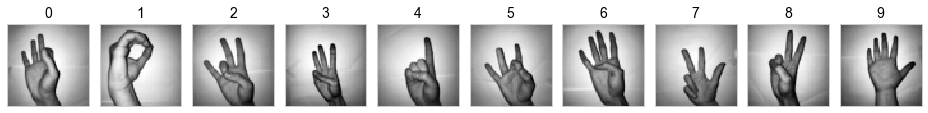

In [3]:
_ , Values = np.nonzero(y[:,:])
Values = pd.Series(Values)

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(13, 8), subplot_kw={'xticks': [], 'yticks': []})

Ind = [Values[Values == i].index.min() for i in Values.unique()]
for i in range(len(ax)):
    ax[i].imshow(X[Ind[i],:,:], cmap = 'gray')
    ax[i].set_title('%i' % np.nonzero(y[Ind[i],:]))
    
fig.tight_layout()

## Train and Test sets

Let's split the data into random train and test subsets using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [4]:
y = Values
del Values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
                   'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(1649, 64, 64)","(413, 64, 64)","(1649,)","(413,)"


In [5]:
def Flat(Inp): return Inp.reshape(Inp.shape[0],Inp.shape[1]*Inp.shape[2])

X_train, X_test = Flat(X_train), Flat(X_test)
pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
                   'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set,X_train,X_test,y_train,y_test
Shape,"(1649, 4096)","(413, 4096)","(1649,)","(413,)"


## Classifiers

In [6]:
classifiers = [
    ('Nearest Neighbors', KNeighborsClassifier(n_neighbors = len(np.unique(y)), weights = 'uniform')),
    ('Linear SVM', SVC(kernel="linear", C=0.025, gamma = 'auto', probability = True)),
    ('RBF SVM', SVC(kernel="rbf", C=1, gamma = 'auto', probability = True)),
    ('Gaussian Process', GaussianProcessClassifier(kernel = 1.0 * RBF(1.0))),
    ('Decision Tree', DecisionTreeClassifier(max_features = None, random_state = 0)),
    ('Random Forest', RandomForestClassifier(n_estimators = 100, oob_score = True)),
#     ('Neural Network', MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
#                                      solver='lbfgs', random_state=0, learning_rate_init=.1)),
    ('AdaBoost', AdaBoostClassifier(n_estimators = 100, algorithm =  'SAMME.R', random_state = 0)),
    ('Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis())]

Performance = []
classifiers_names = []
for (name, clf) in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    classifiers_names.append(name)
    Performance.append([clf.score(X_test, y_test),
                        f1_score(y_test.values, y_pred, average= 'weighted'),
                        precision_score(y_test.values, y_pred, average= 'weighted'),
                        recall_score(y_test.values, y_pred, average= 'weighted')])
del clf, name, y_pred
Performance = pd.DataFrame(Performance,
                           columns=['Score','F1 Score', 'Precision Score', 'Recall Score'], index = classifiers_names) 

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: SpringGreen' if v else '' for v in is_max]

display(Performance.style.apply(highlight_max, subset=['Score']))

,Score,F1 Score,Precision Score,Recall Score
Nearest Neighbors,0.721550,0.721378,0.740337,0.721550
Linear SVM,0.823245,0.823315,0.829169,0.823245
RBF SVM,0.445521,0.382973,0.397911,0.445521
Gaussian Process,0.322034,0.339521,0.634323,0.322034
Decision Tree,0.564165,0.564817,0.570905,0.564165
Random Forest,0.789346,0.791152,0.796427,0.789346
AdaBoost,0.375303,0.355666,0.349734,0.375303
Naive Bayes,0.631961,0.629738,0.639181,0.631961
QDA,0.215496,0.212776,0.216864,0.215496


## Stackeding Classifier

Here we stack classifiers that have at least a 0.5 accuracy level.

In [7]:
Temp = Performance.loc[Performance.Score>=.6].sort_values(by=Performance.columns.tolist(), ascending=False).index.tolist()
New_list = []
for (name, clf) in classifiers:
    if name in Temp:
        New_list.append((name, clf))
    if name in Temp[0]:
        Best = (name, clf)
        
stacked = StackingClassifier(estimators = New_list, final_estimator=Best[1])
stacked.fit(X_train, y_train)
del Temp, name, clf

Temp = [stacked.score(X_test, y_test),
        f1_score(y_test.values, stacked.predict(X_test), average= 'weighted'),
        precision_score(y_test.values, stacked.predict(X_test), average= 'weighted'),
        recall_score(y_test.values, stacked.predict(X_test), average= 'weighted')]
Temp = pd.DataFrame(Temp, index = Performance.columns, columns = ['Stacked Classifier']).T

Temp0 = [name for (name,_) in New_list]
Temp0.append(Temp.index.tolist()[0])

Performance = Performance.loc[Performance.index.isin(Temp0)].append(Temp)\
            .sort_values(by=Performance.columns.tolist(), ascending=False)

Performance.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True), subset=['Score'] )

,Score,F1 Score,Precision Score,Recall Score
Stacked Classifier,0.835351,0.837061,0.842212,0.835351
Linear SVM,0.823245,0.823315,0.829169,0.823245
Random Forest,0.789346,0.791152,0.796427,0.789346
Nearest Neighbors,0.721550,0.721378,0.740337,0.721550
Naive Bayes,0.631961,0.629738,0.639181,0.631961


The stacking classifier improved the accuracy of our classifications.

***